In [ ]:
import pandas as pd
from xgboost import XGBClassifier
import pickle
import numpy as np
import time
import multiprocessing as mp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
covid_df = pd.read_csv('./cases_train_processed.csv')

In [ ]:
# SPLITTING DATA SETS

In [ ]:
x = covid_df.drop('outcome', axis=1)
x_encoded = pd.get_dummies(x)
y = covid_df['outcome']

x_train_encoded, x_val_encoded, y_train, y_val = train_test_split(x_encoded, 
                                                                  y, 
                                                                  test_size=.2, 
                                                                  random_state=7)

In [ ]:
# BUILD MODELS

In [ ]:
# XGBoost pros: 
# 1. Works well for unscaled/non-normalized data
# 2. Handles large data sets
# 3. One of the most accurate classification models
# 4. Reduces bias

xgb = XGBClassifier(max_depth=5, random_state=7)
xgb.fit(x_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pickle.dump(xgb, open('xgb_classifier.pkl', 'wb'))

In [ ]:
# Random Forest pros:
# 1. Can handle features that are highly correlated such as deaths and case-fatality_ratio 
# 2. Better than decision tree as random forest minimizes error of each tree, decreasing variance
# 3. Can handle large amounts of data
# 4. Uses dimensionality reduction for generalization
# 5. Can be used for numerical and categorical data

rf = RandomForestClassifier(max_depth=5, random_state=7)
rf.fit(x_train_encoded, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [ ]:
pickle.dump(rf, open('rf_classifier.pkl', 'wb'))

In [ ]:
# KNN pros:
# 1. Simple to understand
# 2. No assumption about data

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_encoded, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
pickle.dump(knn, open('knn_classifier.pkl', 'wb'))

In [ ]:
# EVALUATION

In [ ]:
xgb = pickle.load(open('xgb_classifier.pkl', 'rb'))
rf = pickle.load(open('rf_classifier.pkl', 'rb'))
knn = pickle.load(open('knn_classifier.pkl', 'rb'))

In [ ]:
xgb_train_predictions = xgb.predict(x_train_encoded)
xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)
print(xgb_train_accuracy)

0.7647248688489762


In [ ]:
xgb_val_predictions = xgb.predict(x_val_encoded)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)
print(xgb_val_accuracy)

0.765582611537833


In [ ]:
rf_train_predictions = rf.predict(x_train_encoded)
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
print(rf_train_accuracy)

0.7093636111065714


In [ ]:
rf_val_predictions = rf.predict(x_val_encoded)
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
print(rf_val_accuracy)

0.7108841313940186


In [ ]:
knn_train_predictions = knn.predict(x_train_encoded)
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)
print(knn_train_accuracy)

0.8202127833434114


In [ ]:
knn_val_predictions = knn.predict(x_val_encoded)
knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)
print(knn_val_accuracy)

0.8109495015525413


In [ ]:
# CHECKING FOR OVERFITTING WITH HYPERPARAMETER TUNING

In [ ]:
# Input model_type and hyperparameters separately so the models can be created in parallel.
def predict(x_train, y_train, x_val, model_type, **hyperparameters):
  model = model_type(**hyperparameters)
  model.fit(x_train, y_train)
  return model.predict(x_val)

In [ ]:
# To test method using Process class, make a version of predict that appends model predictions
# to predictions parameter

# # Testing predict function with different methods of sequential/parallel computing
# x_train_encoded_sample = x_train_encoded.head(100000)
# y_train_sample = y_train.head(100000)
# x_val_encoded_sample = x_val_encoded.head(100000)

# # RF validation sequential
# max_depths = np.linspace(5, 25, 3, dtype=int)
# start = time.perf_counter()
# predictions = []
# for i in max_depths:
#   predictions.append(predict(x_train_encoded_sample, 
#                              y_train_sample, 
#                              x_val_encoded_sample, 
#                              RandomForestClassifier, 
#                              predictions, 
#                              max_depth=i, 
#                              random_state=7))

# end = time.perf_counter()
# print('Sequential:', end-start, 'seconds')
# predictions = np.array(predictions)
# print(predictions)
# rf_val_preds = pd.DataFrame(predictions.T, columns=max_depths)

# # RF validation using Process
# processes = []
# max_depths = np.linspace(5, 25, 3, dtype=int)
# start = time.perf_counter()
# manager = multiprocessing.Manager()
# predictions = manager.list()
# for i in max_depths:
#   p = multiprocessing.Process(target=predict, 
#                               args=(x_train_encoded_sample, y_train_sample, x_val_encoded_sample, RandomForestClassifier, predictions), 
#                               kwargs={'max_depth': i, 'random_state': 7})
#   processes.append(p)
#   p.start()

# for p in processes:
#   p.join()

# end = time.perf_counter()
# print('Process:', end-start, 'seconds')

# # RF validation using Pool
# max_depths = np.linspace(5, 25, 3, dtype=int)
# predictions = []
# start = time.perf_counter()
# pool = mp.Pool(mp.cpu_count())
# for i in n_neighbors:
#   predictions.append(pool.apply(predict, 
#                                 args=(x_train_encoded_sample, y_train_sample, x_val_encoded_sample, KNeighborsClassifier, predictions),
#                                 kwds={'n_neighbors': i}))
# pool.close()
# end = time.perf_counter()
# print('Pool:', end-start, 'seconds')

In [ ]:
# XGB train
predictions = []
max_depths = np.linspace(5, 25, 3, dtype=int)
start = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
for i in max_depths:
  predictions.append(pool.apply(predict, 
                                args=(x_train_encoded, y_train, x_train_encoded, XGBClassifier),
                                kwds={'max_depth': i, 'random_state': 7}))
pool.close()
end = time.perf_counter()
print(end-start, 'seconds')
predictions = np.array(predictions)
xgb_train_preds = pd.DataFrame(predictions.T, columns=max_depths)

29758.654657918 seconds


In [ ]:
# XGB validation
predictions = []
max_depths = np.linspace(5, 25, 3, dtype=int)
start = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
for i in max_depths:
  predictions.append(pool.apply(predict, 
                                args=(x_train_encoded, y_train, x_val_encoded, XGBClassifier),
                                kwds={'max_depth': i, 'random_state': 7}))
pool.close()
end = time.perf_counter()
print(end-start, 'seconds')
predictions = np.array(predictions)
xgb_val_preds = pd.DataFrame(predictions.T, columns=max_depths)

29667.411001052 seconds


In [ ]:
# RF train
predictions = []
max_depths = np.linspace(5, 25, 3, dtype=int)
start = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
for i in max_depths:
  predictions.append(pool.apply(predict, 
                                args=(x_train_encoded, y_train, x_train_encoded, RandomForestClassifier),
                                kwds={'max_depth': i, 'random_state': 7}))
pool.close()
end = time.perf_counter()
print(end-start, 'seconds')
predictions = np.array(predictions)
rf_train_preds = pd.DataFrame(predictions.T, columns=max_depths)

205.76938419600083 seconds


In [ ]:
# RF validation
predictions = []
max_depths = np.linspace(5, 25, 3, dtype=int)
start = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
for i in max_depths:
  predictions.append(pool.apply(predict, 
                                args=(x_train_encoded, y_train, x_val_encoded, RandomForestClassifier),
                                kwds={'max_depth': i, 'random_state': 7}))
pool.close()
end = time.perf_counter()
print(end-start, 'seconds')
predictions = np.array(predictions)
rf_val_preds = pd.DataFrame(predictions.T, columns=max_depths)

198.5224125199993 seconds


In [ ]:
# KNN train
predictions = []
n_neighbors = np.linspace(5, 10, 3, dtype=int)
start = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
for i in n_neighbors:
  predictions.append(pool.apply(predict, 
                                args=(x_train_encoded, y_train, x_train_encoded, KNeighborsClassifier),
                                kwds={'n_neighbors': i}))
pool.close()
end = time.perf_counter()
print(end-start, 'seconds')
predictions = np.array(predictions)
knn_train_preds = pd.DataFrame(predictions.T, columns=n_neighbors)

12763.292653744 seconds


In [ ]:
# KNN validation
predictions = []
n_neighbors = np.linspace(5, 10, 3, dtype=int)
start = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
for i in n_neighbors:
  predictions.append(pool.apply(predict, 
                                args=(x_train_encoded, y_train, x_val_encoded, KNeighborsClassifier),
                                kwds={'n_neighbors': i}))
pool.close()
end = time.perf_counter()
print(end-start, 'seconds')
predictions = np.array(predictions)
knn_val_preds = pd.DataFrame(predictions.T, columns=n_neighbors)

3465.0072627850004 seconds


In [ ]:
def get_scores(preds, y):
    scores = {}
    for col in preds.columns:
        scores[col] = accuracy_score(y, preds[col])
            
    return scores

def plot_train_vs_val(train_hyperparameter_scores, val_hyperparameter_scores, title):
    train_hps = list(train_hyperparameter_scores.keys())
    train_scores = list(train_hyperparameter_scores.values())

    val_hps = list(val_hyperparameter_scores.keys())
    val_scores = list(val_hyperparameter_scores.values())
    
    plt.plot(train_hps, train_scores, '-', label='train')
    plt.plot(val_hps, val_scores, '-', label='validation')
    
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
xgb_train_scores = get_scores(xgb_train_preds, y_train)
xgb_val_scores = get_scores(xgb_val_preds, y_val)
rf_train_scores = get_scores(rf_train_preds, y_train)
rf_val_scores = get_scores(rf_val_preds, y_val)
knn_train_scores = get_scores(knn_train_preds, y_train)
knn_val_scores = get_scores(knn_val_preds, y_val)

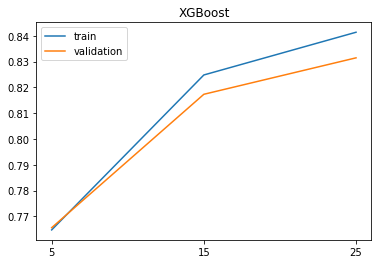

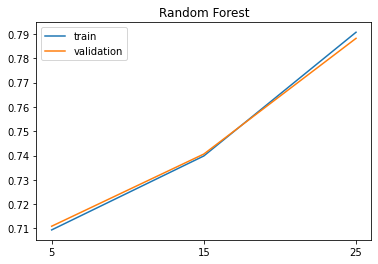

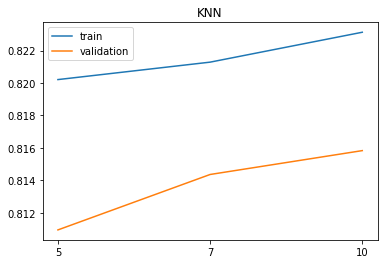

In [ ]:
plot_train_vs_val(xgb_train_scores, xgb_val_scores, 'XGBoost')
plot_train_vs_val(rf_train_scores, rf_val_scores, 'Random Forest')
plot_train_vs_val(knn_train_scores, knn_val_scores, 'KNN')